In [1]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

## Load and Preprocess the Dataset

In [2]:
# Load the Cats vs Dogs dataset
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],  # 80% for training, 20% for testing
    as_supervised=True,                   # Include labels
    with_info=True                        # Metadata about the dataset
)

# Preprocessing function
def preprocess_image(image, label):
    image = tf.image.resize(image, (150, 150))  # Resize to match VGG16 input size
    image = image / 255.0                      # Normalize pixel values to [0, 1]
    return image, label

# Apply preprocessing
ds_train = ds_train.map(preprocess_image).batch(32).shuffle(1000)
ds_test = ds_test.map(preprocess_image).batch(32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.84HN33_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


## VGG16 for Feature Extraction

In [3]:
# Load the pretrained VGG16 model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

# Freeze the convolutional base
vgg_base.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Build the Transfer Learning Model

In [4]:
from tensorflow.keras.layers import GlobalAveragePooling2D

# Build the model
model = Sequential([
    vgg_base,                          # Pretrained base
    GlobalAveragePooling2D(),          # Replace Flatten with GAP for compact representation
    Dense(256, activation='relu'),     # Fully connected layer
    Dense(1, activation='sigmoid')     # Binary classification (cat vs dog)
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,846,273 (56.63 MB)

 Trainable params: 131,585 (514.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Train the Model

In [5]:
# Train the model
history = model.fit(
    ds_train,
    validation_data=ds_test,
    epochs=5
)

Epoch 1/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 98s 108ms/step - accuracy: 0.8252 - loss: 0.3645 - val_accuracy: 0.9024 - val_loss: 0.2334
Epoch 2/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 115s 83ms/step - accuracy: 0.8980 - loss: 0.2375 - val_accuracy: 0.9084 - val_loss: 0.2225
Epoch 3/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 68s 83ms/step - accuracy: 0.9032 - loss: 0.2297 - val_accuracy: 0.9089 - val_loss: 0.2186
Epoch 4/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 69s 83ms/step - accuracy: 0.9075 - loss: 0.2189 - val_accuracy: 0.9125 - val_loss: 0.2108
Epoch 5/5
582/582 ━━━━━━━━━━━━━━━━━━━━ 69s 83ms/step - accuracy: 0.9135 - loss: 0.2035 - val_accuracy: 0.9160 - val_loss: 0.2057


## Evaluate the Model

In [6]:
# Evaluate on test data
test_loss, test_accuracy = model.evaluate(ds_test)
print(f"Test Accuracy: {test_accuracy:.2f}")

146/146 ━━━━━━━━━━━━━━━━━━━━ 10s 66ms/step - accuracy: 0.9231 - loss: 0.1929
Test Accuracy: 0.92


## Visualize Training and Validation Performance

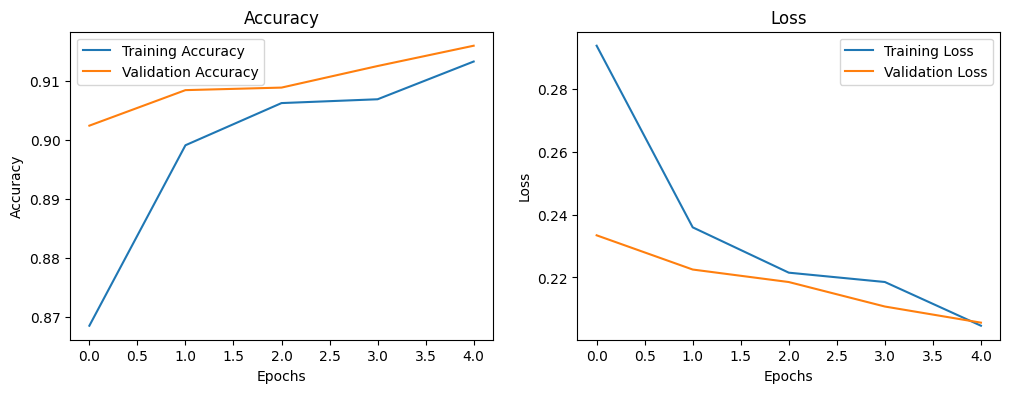

In [7]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Make Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 752ms/step


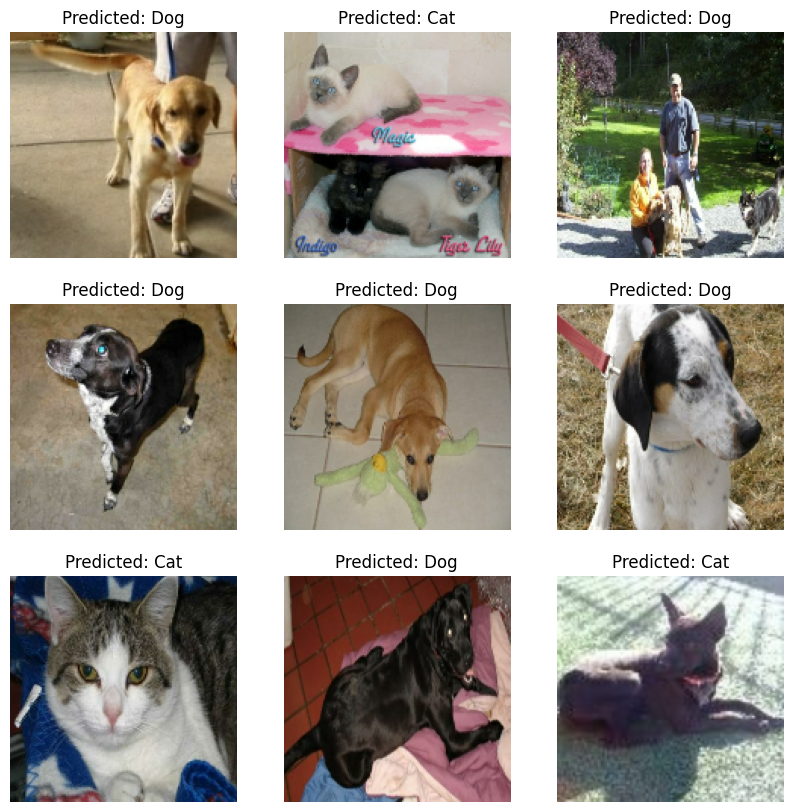

In [8]:
import numpy as np

# Take a batch of test images
for images, labels in ds_test.take(1):
    predictions = model.predict(images)
    predictions = tf.where(predictions > 0.5, 1, 0)  # Convert probabilities to binary predictions

    # Display the images with predictions
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Predicted: {'Dog' if predictions[i] == 1 else 'Cat'}")
        plt.axis('off')
    plt.show()
    break